# Loading and inspecting a model

We eventually want to load up the model we trained and use it for stuff. I don't know why this isn't covered more in the docs. Here, we load the graph, the latest set of variables, and then make and write a new graph after "freezing" all of the trained variables to turn them into constants.

## Reading and inspecting it

We load those files and find the input and output entities of the graph. The graph file is kinda just a bag-o-nodes, so we have to give them useful names when we're building the graph originally. We also can't automatically find the inputs... with anything built into tensorflow.

In [1]:
import tensorflow as tf
graph = tf.Graph()
sess = tf.InteractiveSession(graph=graph)
saver = tf.train.import_meta_graph('savemymodel.meta')
saver.restore(sess,'savemymodel')
tf_x =graph.get_tensor_by_name('THEINPUT:0') 
model=graph.get_tensor_by_name('THEMODEL:0')

INFO:tensorflow:Restoring parameters from savemymodel


Verify that it looks right:

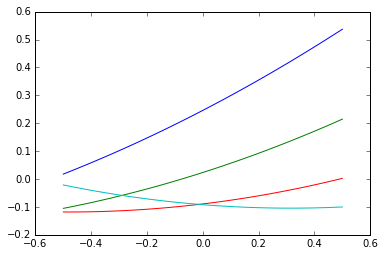

In [2]:
from matplotlib import pylab as plt
import numpy as np
plt.close('all')
for n in np.linspace(-0.5,0.5,4):
    xx = np.zeros((100,2))
    strip = np.linspace(-0.5,0.5,100)
    xx[:,0] = strip
    xx[:,1] = n
    yy = model.eval(feed_dict={tf_x: xx}, session=sess)
    plt.plot(strip,yy,'-')
plt.show()

Lets walk the TensorFlow operation tree and see what it looks like:

In [3]:
from afqstensorutils import *
travel_op((model.op))

THEMODEL  :  Add
    MatMul  :  MatMul
        concat  :  ConcatV2
            THEINPUT  :  Placeholder
            stack  :  Pack
                mul  :  Mul
                    strided_slice  :  StridedSlice
                        THEINPUT  :  Placeholder
                        strided_slice/stack  :  Const
                        strided_slice/stack_1  :  Const
                        strided_slice/stack_2  :  Const
                    strided_slice_1  :  StridedSlice
                        THEINPUT  :  Placeholder
                        strided_slice_1/stack  :  Const
                        strided_slice_1/stack_1  :  Const
                        strided_slice_1/stack_2  :  Const
                mul_1  :  Mul
                    strided_slice_2  :  StridedSlice
                        THEINPUT  :  Placeholder
                        strided_slice_2/stack  :  Const
                        strided_slice_2/stack_1  :  Const
                        strided_slice_2/stack_2  :  Con

## Freezing the model

What we loaded was the graph that was being operated on during optimization. We're done optimizing (for now), so we want to trim down the graph into something that's faster to evaluate and load. This library routine almost does the trick: 

In [4]:
output_graph_def = \
tf.graph_util.convert_variables_to_constants(sess,graph.as_graph_def(),["THEMODEL"])

INFO:tensorflow:Froze 1 variables.
Converted 1 variables to const ops.


But now we need to turn this graph_def object into a graph, and fetch the nodes

In [5]:
a,b=tf.import_graph_def(output_graph_def,return_elements=['THEINPUT:0','THEMODEL:0'])

In [6]:
a

<tf.Tensor 'import/THEINPUT:0' shape=(?, 2) dtype=float32>

Can we evaluate it?

In [7]:
b.eval(feed_dict={a:np.array([[1.0,2.0]])},session=sess)

array([[ 0.40482566]], dtype=float32)

Lets travel the op and see how it compares to what we loaded. It looks exactly the same, but with all the variables replaced by constants. 

In [8]:
travel_op(b.op)

import/THEMODEL  :  Add
    import/MatMul  :  MatMul
        import/concat  :  ConcatV2
            import/THEINPUT  :  Placeholder
            import/stack  :  Pack
                import/mul  :  Mul
                    import/strided_slice  :  StridedSlice
                        import/THEINPUT  :  Placeholder
                        import/strided_slice/stack  :  Const
                        import/strided_slice/stack_1  :  Const
                        import/strided_slice/stack_2  :  Const
                    import/strided_slice_1  :  StridedSlice
                        import/THEINPUT  :  Placeholder
                        import/strided_slice_1/stack  :  Const
                        import/strided_slice_1/stack_1  :  Const
                        import/strided_slice_1/stack_2  :  Const
                import/mul_1  :  Mul
                    import/strided_slice_2  :  StridedSlice
                        import/THEINPUT  :  Placeholder
                        import/strid

Some example code mentioned this, but it's not the way to do it anymore, it seems.

In [9]:
from tensorflow.python.tools import freeze_graph
